#  Understanding Police Fatal Shootings

Notebook for analyzing police fatal shooting factors related to race.

Source: Phil Mui

Reference: bit.ly/mui-asdrp

Data Download and Pre-Processing from [Mapping Police Violence](https://mappingpoliceviolence.us/s/MPVDatasetDownload.xlsx)

In [1]:
#importing useful libraries
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
# import psycopg2 as ps

In [24]:
df = pd.read_csv("../data/police-violence.csv")

In [26]:
df.shape

(10205, 62)

In [27]:
df.head(2)

,name,age,gender,race,victim_image,date,street_address,city,state,zip,...,congressperson_party,prosecutor_head,prosecutor_race,prosecutor_gender,prosecutor_party,prosecutor_term,prosecutor_in_court,prosecutor_special,independent_investigation,prosecutor_url
0,David C. Moran,74.0,Male,White,https://tributecenteronline.s3-accelerate.amaz...,4/9/2022,NaN,Greensburg,KY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,James Wesley Morrison,49.0,Male,White,https://www.readfrontier.org/wp-content/upload...,4/7/2022,60th Ave SE and State Highway 9,Norman,OK,73026.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df = df[['name', 'age', 'gender', 'race', 'date', 'city', 'state', 'zip', 'county', 'agency_responsible', 'cause_of_death', 'counter_type', 'initial_reason']]

In [31]:
df.tail(2)

,name,age,gender,race,date,city,state
10203,Abel Gurrola,26.0,Male,Hispanic,1/1/2013,Bakersfield,CA
10204,Andrew Layton,26.0,Male,White,1/1/2013,Mankato,MN


In [34]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#creates a one-hot encoder function which returns a column of our dataframe one-hot encodeded as well as their categorical name (given input of the column) 

def one_hot_encode(data):
  values = array(data)
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  shape = onehot_encoded.shape
  inverted = []
  for i in range(shape[-1]):
      inverted.append(label_encoder.inverse_transform([i]))
  return onehot_encoded, inverted

In [35]:
# declares output array
outputs = [[] for i in range(len(df))] 

In [37]:
#creates inputs [1,0] = African American Killing by Police, [0,1] = non African American Killing by Police
races = df["race"] 
count = 0
for race in races:
  if(race == "Black"):
    outputs[count].append(1)
    outputs[count].append(0)
  else:
    outputs[count].append(0)
    outputs[count].append(1)
  count += 1
df = df.drop(columns = "race")

In [38]:
xOutputs = []
for race in races:
  if(race == "Black"):
    xOutputs.append(1)
  else:
    xOutputs.append(0)

In [39]:
len(xOutputs)

10205

In [40]:
# creates inputs by one-hot encoding individual dataframe columns
# inverted is a list of categorical data which corresponds to each "1" in the one-hot encoding
inputs = list()
inverted = []
for column in df: 
  check = array(df[column])
  encodedArray = one_hot_encode(check)[0]
  inverted.extend(one_hot_encode(check)[1])
  inputs.append(encodedArray)
inputs = np.hstack(inputs)


In [41]:
# code for undersampling
#import random
#temp = list(zip(inputs, outputs)) 
#random.shuffle(temp) 
#inputs, outputs = zip(*temp)

In [42]:
#count = 0
#countx = 0
#for i in range(len(outputs)):
#  if(outputs[i][0] == 1):
#    count += 1
#  if(outputs[i][0] == 0):
#    countx += 1
#check = 0
#newInputs = []
#newOutputs = []
#inputs = list(inputs)
#outputs = list(outputs)
#for i in range(len(inputs) - 1):
#  if(check < abs(count-countx)):
#    if(outputs[i][1] == 0):
#      newInputs.append(inputs[i])
#      newOutputs.append(outputs[i])
#    else:
#      check += 1
#  else:
#    newInputs.append(inputs[i])
#    newOutputs.append(outputs[i])

In [43]:
#import random
#temp = list(zip(newInputs, newOutputs)) 
#random.shuffle(temp) 
#newInputs, newOutputs = zip(*temp)

In [44]:
len(inputs)


10205

In [45]:
len(xOutputs)

10205

In [51]:
# summarize class distribution
print(Counter(xOutputs))

Counter({0: 7664, 1: 2541})


In [46]:
import sklearn.utils._cython_blas
import imblearn

In [47]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversample = RandomOverSampler(sampling_strategy='minority')
newInputs, newOutputs = oversample.fit_resample(inputs, xOutputs)
# summarize class distribution
print(Counter(newOutputs))

Counter({0: 7664, 1: 7664})


In [48]:
import random
temp = list(zip(newInputs, newOutputs)) 
random.shuffle(temp) 
newInputs, newOutputs = zip(*temp)

In [49]:
# creates a train/test split of 80-20
newOutputs = np.array(newOutputs)
split = int(0.7*len(newInputs))
X_train, X_test, y_train, y_test = newInputs[:split], newInputs[split:], newOutputs[:split], newOutputs[split:]
X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LSTM, Flatten, Conv1D
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights= True)
model = Sequential()
model.add(Flatten())
model.add(Dense(2000, activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(1, activation = 'relu'))
model.compile(loss = "MSE", optimizer = "Adam", metrics=["accuracy"])


2022-06-17 10:32:16.469113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
# fits the model to the training data
# it is extremely important to use class_weights as otherwise, the model only predicts one class (as 68% of the inputs are non-African American Killings)
# this ensures that our model is fair and treats the individual accuracy of each class' classification the same
model.fit(X_train, y_train,
            batch_size=16,
            epochs= 20,
            validation_split = 0.2, 
            )

Epoch 1/20
537/537 [==============================] - 50s 91ms/step - loss: 0.1694 - accuracy: 0.7546 - val_loss: 0.1174 - val_accuracy: 0.8546
Epoch 2/20
537/537 [==============================] - 48s 90ms/step - loss: 0.0475 - accuracy: 0.9600 - val_loss: 0.1061 - val_accuracy: 0.8569
Epoch 3/20
537/537 [==============================] - 48s 90ms/step - loss: 0.0183 - accuracy: 0.9906 - val_loss: 0.1141 - val_accuracy: 0.8383
Epoch 4/20
537/537 [==============================] - 49s 91ms/step - loss: 0.0123 - accuracy: 0.9951 - val_loss: 0.1093 - val_accuracy: 0.8490
Epoch 5/20
537/537 [==============================] - 49s 91ms/step - loss: 0.0114 - accuracy: 0.9928 - val_loss: 0.1101 - val_accuracy: 0.8444
Epoch 6/20
537/537 [==============================] - 49s 91ms/step - loss: 0.0094 - accuracy: 0.9950 - val_loss: 0.1027 - val_accuracy: 0.8779
Epoch 7/20
537/537 [==============================] - 49s 91ms/step - loss: 0.0071 - accuracy: 0.9958 - val_loss: 0.1004 - val_accuracy:

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16753)             0         
                                                                 
 dense (Dense)               (None, 2000)              33508000  
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 200)               400200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 33,908,401
Trainable params: 33,908,401
No

In [55]:
from sklearn.metrics import f1_score
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if(preds[i] < 0.5):
    preds[i] = 0
  else:
    preds[i] = 1      
for i in range(len(preds)):
  if(preds[i].round() == y_test[i]):
    num_correct += 1
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))
f1_score(y_test, preds, average = None)

144/144 [==============================] - 2s 14ms/step
The fraction of correctly classified examples in the test set is: 0.8871493803000652


array([0.89292346, 0.88071708])

In [56]:
# creates a train/test split of 80-20
newOutputs = np.array(newOutputs)
split = int(0.8*len(newInputs))
X_train, X_test, y_train, y_test = newInputs[:split], newInputs[split:], newOutputs[:split], newOutputs[split:]

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import f1_score
model = tree.DecisionTreeClassifier(max_depth= 5000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if(preds[i] < 0.5):
    preds[i] = 0
  else:
    preds[i] == 1
for i in range(len(preds)):
  if(preds[i].round() == y_test[i]):
    num_correct += 1
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))
f1_score(y_test, preds, average = None)

The fraction of correctly classified examples in the test set is: 0.8887801696020874


array([0.88357801, 0.89353731])

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
model = RandomForestClassifier(300)
model.fit(X_train, y_train)
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if(preds[i] < 0.5):
    preds[i] = 0
  else:
    preds[i] == 1
for i in range(len(preds)):
  if(preds[i].round() == y_test[i]):
    num_correct += 1
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))
f1_score(y_test, preds, average = None)

The fraction of correctly classified examples in the test set is: 0.9151989562948467


array([0.91315965, 0.91714468])

In [91]:
! pip install graphviz

# if you are using mac:
! brew install graphviz

# if you are using Ubuntu
! sudo apt-get install graphivz

# if you are using Windows
! echo "You need to install GraphViz executable from web first"

In [92]:
import graphviz
model = tree.DecisionTreeClassifier(max_depth= 4)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [93]:
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=inverted,  
                                class_names= ["AA", "nonAA"],
                                filled=True)

In [94]:
graph = graphviz.Source(dot_data, format="png") 

In [95]:
import pydotplus
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

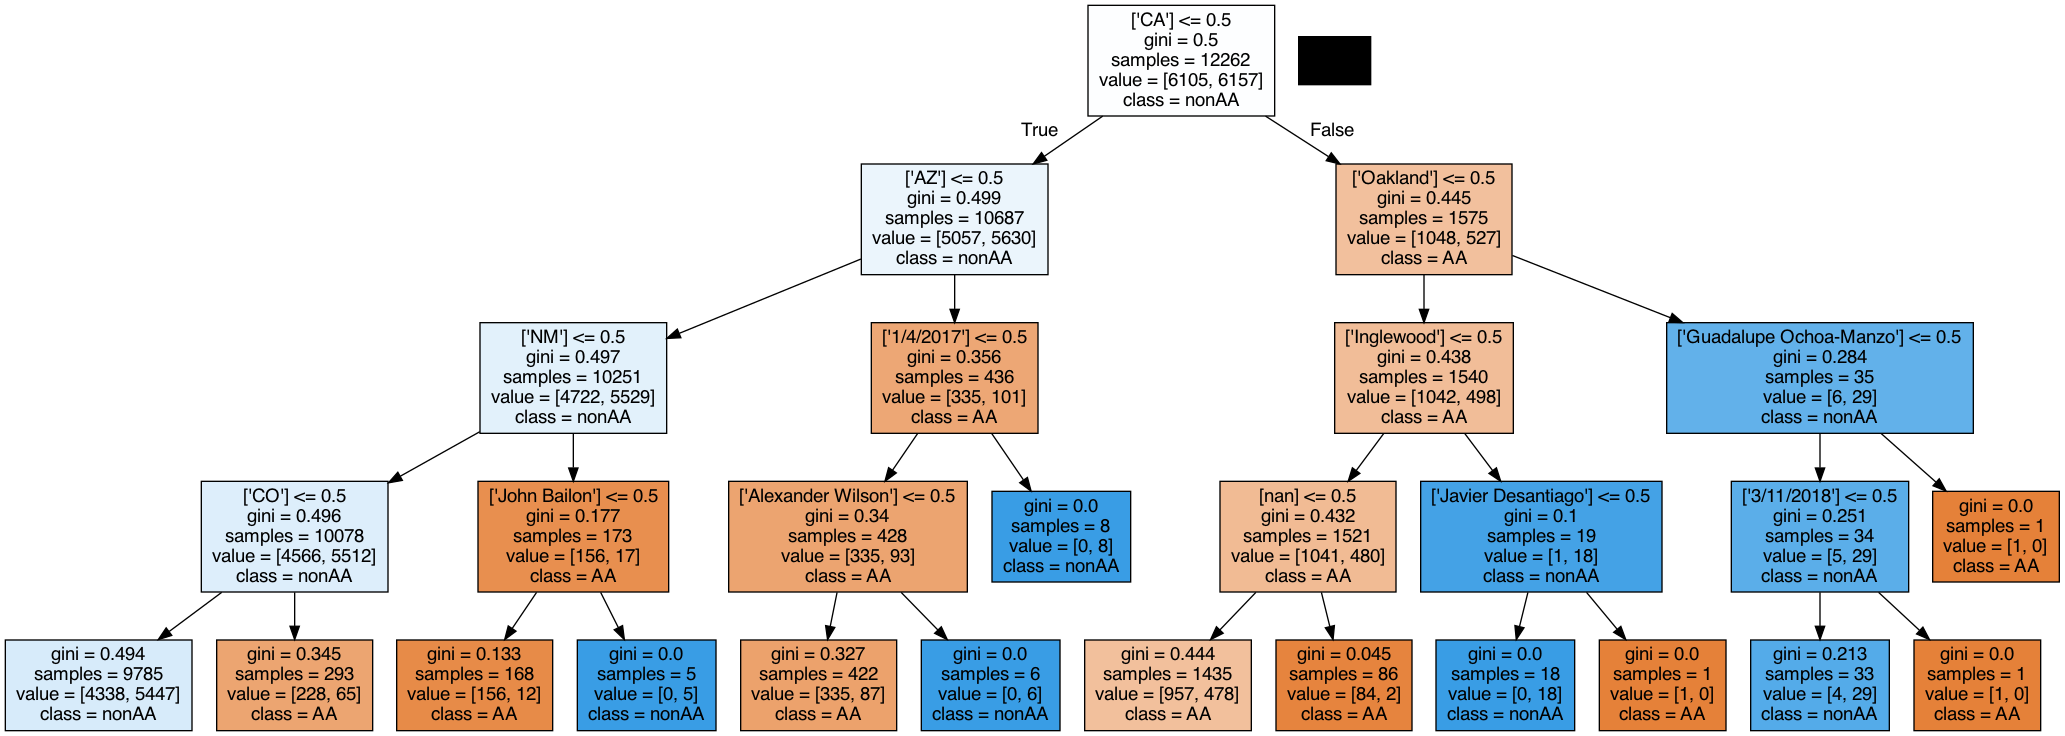

In [97]:
from IPython.display import Image
Image(pydot_graph.create_png())

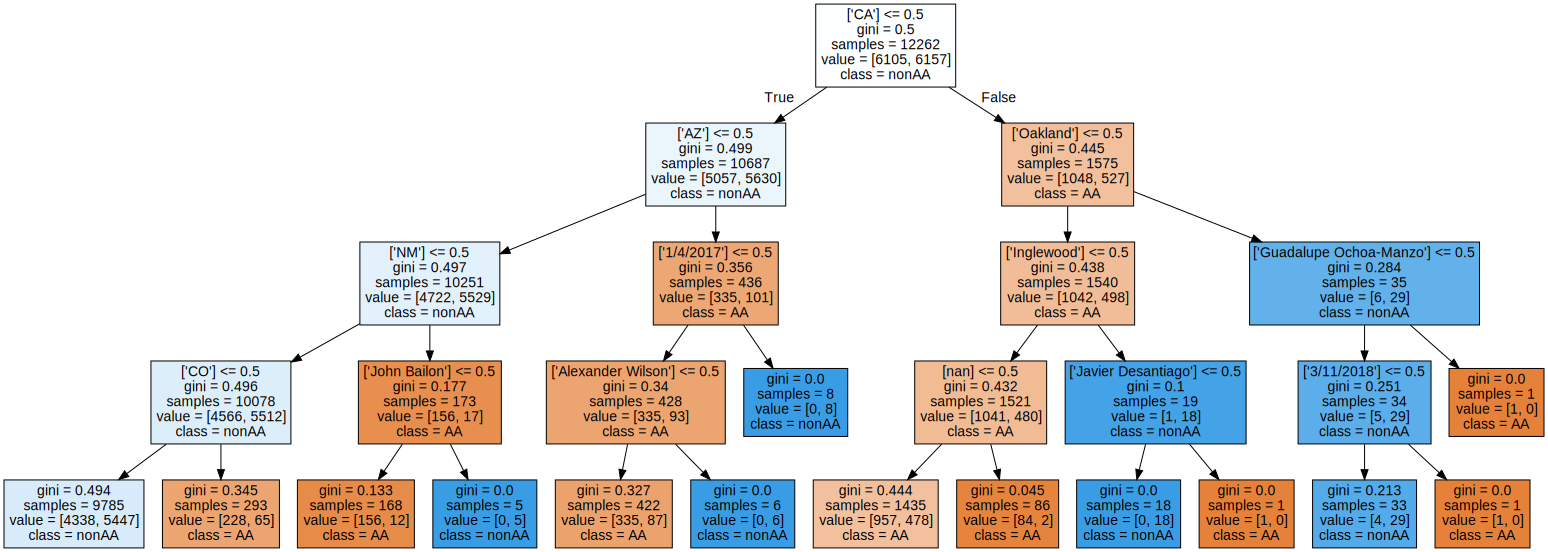

In [99]:
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
from sklearn.metrics import accuracy_score
accuracies = []
medAccuracies = []
depths = []

# this takes many HOURS -- be ready to get 8+ hours sleep!
for i in range(5,500, 5):
  print(i)
  depths.append(i)
  model = RandomForestClassifier(300, max_depth=i)
  model.fit(X_train, y_train)
  estimatorAccuracy=[]
  for curEstimator in range(300):
    estimatorAccuracy.append([curEstimator,accuracy_score(y_test, model.estimators_[curEstimator].predict(X_test))])

  estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
  estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)
  estimatorAccuracy = estimatorAccuracy.reset_index(drop=True)

  bestAccuracy= estimatorAccuracy['Accuracy'][0]
  accuracies.append(bestAccuracy)
  medAccuracies.append(estimatorAccuracy['Accuracy'][(len(estimatorAccuracy)/2) + 1])


estimatorAccuracy.head()

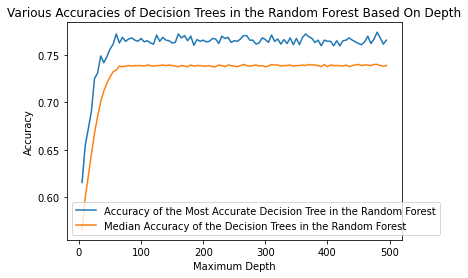

In [ ]:
plt.title("Various Accuracies of Decision Trees in the Random Forest Based On Depth")
plt.plot(depths, accuracies, label = "Accuracy of the Most Accurate Decision Tree in the Random Forest")
plt.plot(depths, medAccuracies, label = "Median Accuracy of the Decision Trees in the Random Forest")

plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.legend()

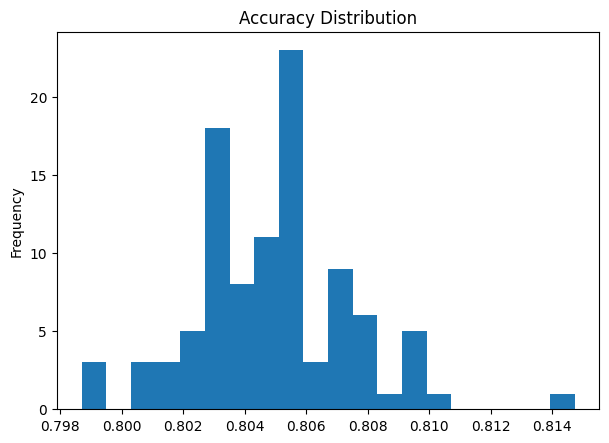

In [ ]:
import matplotlib.pyplot as plt # has a different graph nearly every time, but the range of accuracies is always similar, which is what the graph is used for
answers = []
for i in range(100):
  model = RandomForestClassifier(300) 
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  check = 0
  num_correct = 0
  for i in range(len(preds)):
    if(preds[i] < 0.5):
      preds[i] = 0
    else:
      preds[i] == 1
  for i in range(len(preds)):
    if(preds[i].round() == y_test[i]):
      num_correct += 1
  answers.append(num_correct / len(preds))

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(answers, bins=20)
plt.gca().set(title='Accuracy Distribution', ylabel='Frequency');

In [101]:
from sklearn import svm
from sklearn.metrics import f1_score
model = svm.SVC()
model.fit(X_train, y_train)
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if(preds[i] < 0.5):
    preds[i] = 0
  else:
    preds[i] == 1
for i in range(len(preds)):
  if(preds[i].round() == y_test[i]):
    num_correct += 1
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))
f1_score(y_test, preds, average = None)

The fraction of correctly classified examples in the test set is: 0.8923679060665362


array([0.89144737, 0.89327296])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
model = GradientBoostingClassifier(n_estimators = 300, max_depth= None)
model.fit(X_train, y_train)
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if(preds[i] < 0.5):
    preds[i] = 0
  else:
    preds[i] == 1
for i in range(len(preds)):
  if(preds[i].round() == y_test[i]):
    num_correct += 1
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import f1_score
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if(preds[i] < 0.5):
    preds[i] = 0
  else:
    preds[i] == 1
for i in range(len(preds)):
  if(preds[i].round() == y_test[i]):
    num_correct += 1
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))
f1_score(y_test, preds, average = None)